In [1]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

from imblearn.over_sampling import SMOTE

import pandas as pd
import pennylane as qml
import numpy as np

from sklearn.model_selection import train_test_split # data split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt

2023-04-10 21:28:43.099756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Data Prep 
df = pd.read_csv('creditcard.csv')

df.drop('Time', axis = 1, inplace = True)
print('Calculate duplicated data arrays', df.duplicated().sum())
df.drop_duplicates(keep=False,inplace=True)

#Drop the Classification column 
Vcolumns = df.drop('Class', axis = 1).values 

#Classification fraud/non-fraud column
y = df['Class'].values 

# Divide into training and testing data: 80% training and 20% testing
testtotrain = 0.2
X_train, X_test, y_train, y_test = train_test_split(Vcolumns, y, test_size = testtotrain, random_state = 0)

# optional use SMOTE to balance non-fraud/fraud transactions
if smote:
    print("Frauds in train before SMOTE", np.sum(y_train))
    os = SMOTE(sampling_strategy='minority',random_state = 1,k_neighbors=5)
    X_train,y_train = os.fit_resample(X_train,y_train)
    print("Frauds in train after SMOTE", np.sum(y_train))

Calculate duplicated data arrays 9144


In [49]:
# Hybrid Classical-Quantum Neural Network

#---------Classical Layer 1----------
clayer_1 = tf.keras.layers.Dense(2, activation="sigmoid")
print("Classical layer 1 created")


#--------Quantum Layer----------
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
print("Quantum layer created")


#---------Classical Layer 2-----------
clayer_2 = tf.keras.layers.Dense(1, activation="sigmoid")
print("Classical layer 2 created")


#Create the hybrid model
model = tf.keras.models.Sequential([clayer_1, qlayer, clayer_2])
print("Quantum and classical layers added")

Classical layer 1 created
Quantum layer created
Classical layer 2 created
Quantum and classical layers added


In [51]:
# Model Training
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(opt, loss="mae", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size = 10, epochs = 5,validation_split=0.2)

Epoch 1/5
17313/17313 [==============================] - 51182s 3s/step - loss: 0.0135 - accuracy: 0.9981 - val_loss: 0.0037 - val_accuracy: 0.9983
Epoch 2/5
17313/17313 [==============================] - 41660s 2s/step - loss: 0.0032 - accuracy: 0.9982 - val_loss: 0.0027 - val_accuracy: 0.9983
Epoch 3/5
17313/17313 [==============================] - 85218s 5s/step - loss: 0.0026 - accuracy: 0.9982 - val_loss: 0.0024 - val_accuracy: 0.9983
Epoch 4/5
17313/17313 [==============================] - 46725s 3s/step - loss: 0.0023 - accuracy: 0.9982 - val_loss: 0.0022 - val_accuracy: 0.9983
Epoch 5/5
17313/17313 [==============================] - 18784s 1s/step - loss: 0.0022 - accuracy: 0.9982 - val_loss: 0.0021 - val_accuracy: 0.9983


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 2)                 60        
                                                                 
 keras_layer_15 (KerasLayer)  (None, 2)                12        
                                                                 
 dense_31 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________
None


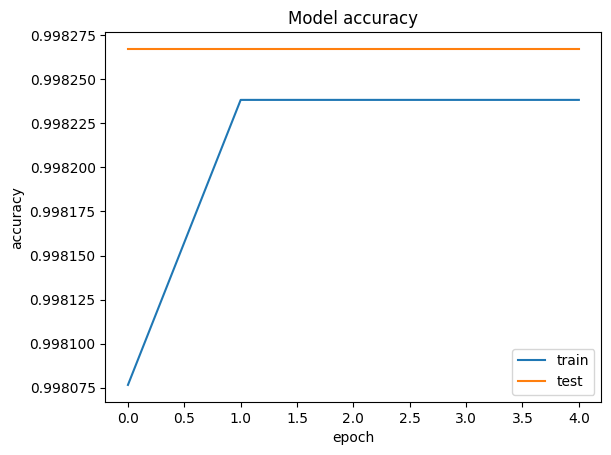

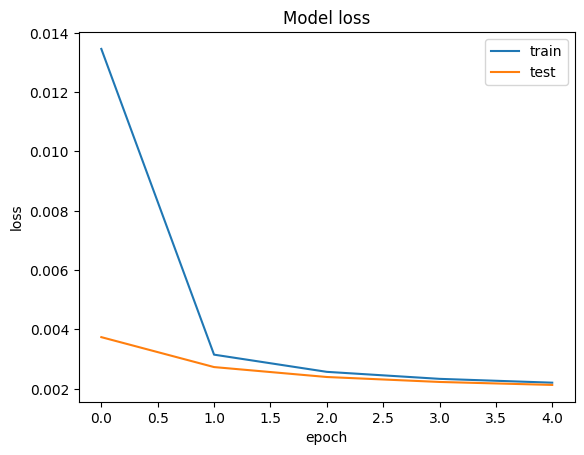

Max val_acc achieved: 99.83 %
Max acc achieved: 99.82 %


In [52]:
# Loss and Accuracy

print(model.summary())

# Plot history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()


# Plot history of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

print('Max val_acc achieved: %.2f' %(max(history.history['val_accuracy'])*100), '%')
print('Max acc achieved: %.2f' %(max(history.history['accuracy'])*100), '%')

In [60]:
#Confusion matrix
y_pred = model.predict(X_test)
ann_cm = confusion_matrix(y_test, y_pred.round())
ann_acc = round(accuracy_score(y_pred.round(),y_test) * 100, 2)
print(ann_cm)
print(ann_acc,'%')
print(classification_report(y_pred.round(),y_test))

1691/1691 [==============================] - 1789s 1s/step
[[54023     0]
 [   80     0]]
99.85 %
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54103
         1.0       0.00      0.00      0.00         0

    accuracy                           1.00     54103
   macro avg       0.50      0.50      0.50     54103
weighted avg       1.00      1.00      1.00     54103



/Users/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
